## Industry Factors


This notebook is wholly inspired by Druce Vertes from Streeteye.com, do pay him some support.

Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use industry returns from [Ken French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

2) Forecast (for example) this month's Chemical industry return using last month's returns from all 30 industries 

3) Use LASSO for predictor subset selection over the entire 1960-2016 period to determine that e.g. Beer is predicted by Food, Clothing, Coal

4) Use LASSO-selected predictors and simple linear regression to predict returns

5) Generate portfolios and run backtests.

- Predictor selection - finds same predictors except 2 industries. Possibly use of AICc instead of AIC (don't see an sklearn implementation that uses AICc)

- Prediction by industry - R-squareds line up pretty closely

- Portfolio performance, similar ballpark results. Maybe AICc/AIC; Also paper standardizes predictors, which is pretty standard. Finally, for some reason their mean returns don't line up to geometric mean annualized, they seem to be calculating something different.

- Replicating exactly is hard but it does replicate closely and perform well

6) Run various sklearn regressors to see which performs best, understand metrics that predict performance. MSE does not predict Sharpe. Kendall's tau, i.e. correlation of predicted vs. actual rankings, performs better.

7) Tune ElasticNet to get slightly better performance than Lasso/OLS

8) Run Keras NNs. They don't improve on Lasso/OLS or ElasticNet.


 

In [0]:
#!pip install beakerx

In [0]:
#!pip install tornado==5.1.1

In [0]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators
import xgboost

from scipy.stats import chisquare, kendalltau

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

import keras
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
#from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


1.14.0-rc1
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


### 1. Replicate paper

In [0]:
## Save future files to your drive
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/FirmAI/FinML/Data/Industry Factors"



Mounted at /content/drive
/content/drive/My Drive/FirmAI/FinML/Data/Industry Factors


In [0]:
print("Loading data...")
data = pd.read_csv("input/30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("input/F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)

# Create lead columns
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [0]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,Food.lead,Beer.lead,Smoke.lead,Games.lead,Books.lead,Hshld.lead,Clths.lead,Hlth.lead,Chems.lead,Txtls.lead,Cnstr.lead,Steel.lead,FabPr.lead,ElcEq.lead,Autos.lead,Carry.lead,Mines.lead,Coal.lead,Oil.lead,Util.lead,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,0.72,2.18,3.11,5.53,5.28,-4.88,4.40,2.07,3.93,1.79,3.97,-1.96,0.67,1.46,2.03,-0.30,2.41,2.71,0.15,-6.50,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,-6.67,-9.38,-4.42,-12.30,-11.71,-5.03,-3.81,-7.91,-7.82,-2.40,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,-6.67,-9.38,-4.42,-12.30,-11.71,-5.03,-3.81,-7.91,-7.82,-2.40,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,3.07,-2.03,-2.13,5.11,-2.15,2.05,1.57,-2.97,-3.74,2.48,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,3.07,-2.03,-2.13,5.11,-2.15,2.05,1.57,-2.97,-3.74,2.48,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,-0.78,-5.58,-3.58,-0.89,-6.64,-8.19,-2.99,-5.47,-1.07,1.42,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,-0.78,-5.58,-3.58,-0.89,-6.64,-8.19,-2.99,-5.47,-1.07,1.42,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,-1.45,-5.53,-4.10,-1.11,-2.31,-1.36,-0.81,-2.97,-4.48,1.18,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,-1.45,-5.53,-4.10,-1.11,-2.31,-1.36,-0.81,-2.97,-4.48,1.18,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,3.18,2.35,0.92,6.48,0.27,9.27,-1.39,2.41,-3.85,1.25,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,3.18,2.35,0.92,6.48,0.27,9.27,-1.39,2.41,-3.85,1.25,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,2.54,1.32,1.63,-0.20,-0.29,0.36,-1.41,-1.34,3.38,5.55,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,2.54,1.32,1.63,-0.20,-0.29,0.36,-1.41,-1.34,3.38,5.55,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,-5.17,-2.38,-3.89,-6.96,-1.32,1.75,2.42,2.04,0.54,-1.36,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,-5.17,-2.38,-3.89,-6.96,-1.32,1.75,2.42,2.04,0.54,-1.36,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,0.57,0.63,0.80,-1.04,2.89,6.93,6.94,3.47,3.94,4.29,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,0.57,0.63,0.80,-1.04,2.89,6.93,6.94,3.47,3.94,4.29,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48,-3.88,-5.00,-2.09,-2.33,-6.20,-9.18,-4.23,-8.87,-6.70,-5.25,-5.03,-8.24,-5.69,-10.46,-5.90,-8.73,-2.21,-5.19,-1.08,-4.71,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [0]:
data.to_csv("output/data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,Food.lead,Beer.lead,Smoke.lead,Games.lead,Books.lead,Hshld.lead,Clths.lead,Hlth.lead,Chems.lead,Txtls.lead,Cnstr.lead,Steel.lead,FabPr.lead,ElcEq.lead,Autos.lead,Carry.lead,Mines.lead,Coal.lead,Oil.lead,Util.lead,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.00000,685.00000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,0.690715,0.710613,0.982321,0.701708,0.528277,0.554190,0.669460,0.650905,0.519781,0.667416,0.523460,0.293810,0.562584,0.704219,0.453985,0.718730,0.548657,0.735547,0.650978,0.483606,0.521737,0.683416,0.580482,0.510044,0.582569,0.622657,0.664380,0.705650,0.609212,0.377401,0.689168,0.708613,0.99492,0.70638,0.519971,0.557182,0.666715,0.656949,0.520818,0.676409,0.528029,0.295883,0.564818,0.702496,0.453839,0.728701,0.560292,0.724701,0.638861,0.482526,0.520847,0.694234,0.584175,0.511241,0.582088,0.625562,0.662219,0.702730,0.609810,0.385620
std,4.339811,5.090215,6.061582,7.180918,5.809314,4.759874,6.386027,4.928072,5.518477,7.022552,5.991354,7.294629,6.114140,6.211516,6.689082,6.292859,7.452882,10.193399,5.348388,3.991419,4.629125,6.526231,6.738237,5.054992,5.739414,5.605280,5.349748,6.104997,5.411795,5.821199,4.339528,5.090626,6.06222,7.18257,5.803697,4.760591,6.385915,4.927392,5.519025,7.026588,5.992697,7.295367,6.115352,6.210339,6.688977,6.289385,7.465115,10.195930,5.350350,3.991165,4.628520,6.527984,6.738979,5.055314,5.739306,5.605317,5.349341,6.104515,5.411766,5.815446
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,-28.740000,-32.990000,-31.630000,-32.800000,-36.490000,-31.100000,-34.550000,-38.090000,-18.960000,-12.940000,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000,-18.150000,-20.190000,-25.32000,-33.40000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,-28.740000,-32.990000,-31.630000,-32.800000,-36.490000,-31.100000,-34.550000,-38.090000,-18.960000,-12.940000,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.640000,-2.100000,-2.780000,-3.490000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,-2.880000,-4.120000,-3.050000,-2.990000,-3.350000,-3.220000,-3.980000,-5.050000,-2.660000,-1.860000,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-3.010000,-1.640000,-2.100000,-2.74000,-3.49000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,-2.880000,-4.120000,-3.050000,-2.990000,-3.350000,-3.200000,-3.980000,-5.050000,-2.670000,-1.860000,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-2.990000
50%,0.740000,0.710000,1.280000,0.890000,0.510000,0.750000,0.690000,0.750000,0.670000,0.630000,0.610000,0.220000,0.860000,0.550000,0.260000,0.930000,0.600000,0.400000,0.650000,0.620000,0.610000,0.960000,0.560000,0.690000,0.860000,0.900000,0.470000,1.040000,0.820000,0.470000,0.740000,0.710000,1.29000,0.89000,0.510000,0.780000,0.680000,0.760000,0.670000,0.630000,0.610000,0.220000,0.860000,0.550000,0.260000,0.950000,0.600000,0.380000,0.630000,0.620000,0.610000,0.970000,0.560000,0.690000,0.86

In [0]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.074020
Beer,0.072005
Smoke,0.100147
Games,0.054031
Books,0.043953
Hshld,0.054098
Clths,0.057170
Hlth,0.065463
Chems,0.044917
Txtls,0.051888


In [0]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.086108
Beer,0.088687
Smoke,0.124460
Games,0.087532
Books,0.065268
Hshld,0.068568
Clths,0.083360
Hlth,0.080966
Chems,0.064188
Txtls,0.083096


In [0]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

,std
Food,15.03
Beer,17.63
Smoke,21.00
Games,24.88
Books,20.12
Hshld,16.49
Clths,22.12
Hlth,17.07
Chems,19.12
Txtls,24.33


In [0]:
npredictors

30

In [0]:
# Run LASSO, then OLS on selected variables

# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:] # Predict leads
nrows = X.shape[0]
X.shape

(684, 30)

In [0]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    # For each response variable run AIC 
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.24%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.52%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.55%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.05%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Running OLS for Books.lead against ['Games', 'Books', 'Coal'

In [0]:
# same predictors selected for all but 2 response vars
# Differences might be due to small mechanical differences in the mstatistical tools applied.  
# use predictors from paper to match results
if True: # turn off/on
    coef_dict_temp = {}
    coef_dict_temp['Food.lead'] = ['Clths', 'Coal', 'Util', 'Rtail']
    coef_dict_temp['Beer.lead'] = ['Food', 'Clths', 'Coal']
    coef_dict_temp['Smoke.lead'] = ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
    coef_dict_temp['Games.lead'] = ['Books', 'Clths', 'Coal', 'Fin']
    coef_dict_temp['Books.lead'] = ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Hshld.lead'] = ['Clths', 'Coal', 'Rtail']
    coef_dict_temp['Clths.lead'] = ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry',  'Coal', 'Oil', 'Util','Telcm', 'Servs', 'BusEq', 'Rtail']
    # Running OLS for Clths against ['Clths', 'Coal', 'Oil', 'Servs', 'Rtail']
    coef_dict_temp['Hlth.lead'] = ['Books', 'Mines', 'Coal', 'Util']
    coef_dict_temp['Chems.lead'] = ['Clths']
    coef_dict_temp['Txtls.lead'] = ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Cnstr.lead'] = ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
    coef_dict_temp['Steel.lead'] = ['Fin']
    coef_dict_temp['FabPr.lead'] = ['Trans', 'Fin']
    coef_dict_temp['ElcEq.lead'] = ['Fin']
    coef_dict_temp['Autos.lead'] = ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Carry.lead'] = ['Trans']
    coef_dict_temp['Mines.lead'] = []
    coef_dict_temp['Coal.lead'] = ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 'Oil', 'Paper', 'Rtail']
    coef_dict_temp['Oil.lead'] = ['Beer', 'Hlth', 'Carry']
    coef_dict_temp['Util.lead'] = ['Food', 'Beer', 'Smoke', 'Hshld', 'Hlth', 'Cnstr', 'FabPr', 'Carry', 'Mines', 'Oil', 'Util', 'Telcm', 'BusEq', 'Whlsl', 'Fin', 'Other']
    coef_dict_temp['Telcm.lead'] = ['Beer', 'Smoke', 'Books', 'Hshld', 'Cnstr', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
    coef_dict_temp['Servs.lead'] = ['Smoke', 'Books', 'Steel', 'Oil', 'Util', 'Fin']
    coef_dict_temp['BusEq.lead'] = ['Smoke', 'Books', 'Util']
    coef_dict_temp['Paper.lead'] = ['Clths', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Trans.lead'] = ['Fin']
    coef_dict_temp['Whlsl.lead'] = ['Food', 'Beer', 'Smoke', 'Books', 'Hlth', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Fin', 'Other']
    # Running OLS for Whlsl against ['Food', 'Smoke', 'Books', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'Fin', 'Other']
    coef_dict_temp['Rtail.lead'] = ['Rtail']
    coef_dict_temp['Meals.lead'] = ['Smoke', 'Books', 'Clths', 'Steel', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Meals', 'Fin']
    coef_dict_temp['Fin.lead'] = ['Fin']
    coef_dict_temp['Other.lead'] = ['Clths', 'Fin']
    
coef_dict_paper = []
for response in responses:
    print(response, " -> ", coef_dict_temp[response])
    coef_dict_paper.append([predictor_reverse_dict[jstr] for jstr in coef_dict_temp[response]])
print(coef_dict_paper)

Food.lead  ->  ['Clths', 'Coal', 'Util', 'Rtail']
Beer.lead  ->  ['Food', 'Clths', 'Coal']
Smoke.lead  ->  ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Games.lead  ->  ['Books', 'Clths', 'Coal', 'Fin']
Books.lead  ->  ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Hshld.lead  ->  ['Clths', 'Coal', 'Rtail']
Clths.lead  ->  ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
Hlth.lead  ->  ['Books', 'Mines', 'Coal', 'Util']
Chems.lead  ->  ['Clths']
Txtls.lead  ->  ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
Cnstr.lead  ->  ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
Steel.lead  ->  ['Fin']
FabPr.lead  ->  ['Trans', 'Fin']
ElcEq.lead  ->  ['Fin']
Autos.lead  ->  ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
Carry.lead  ->  ['Trans']
Mines.lead  ->  []
Coal.lead  ->  ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 

In [0]:
# Now just try a simple linear regression on selected features, the idea here is to obtain the same lasso results as the paper
def predict_with_subsets(X, Y, create_model, coef_dict, verbose=False):
    """evaluate subset selection, pass a model function and subsets, compute avg R-squared"""
    global responses

    nrows, ncols = Y.shape
    model = create_model()
    
    scores = []
    for response_col in range(ncols):
        y = Y[:,response_col]

        
        if not coef_dict[response_col]:
            if verbose:
                print("No coefs selected for " + responses[response_col])
 #           print("---")
            continue

        predcols = coef_dict[response_col]
        model.fit(X[:, predcols], y)
        y_pred = model.predict(X[:, predcols])
        score = r2_score(y, y_pred)
        scores.append(score)
        if verbose:
            print ("In-sample R-squared: %.2f%% for %s against %s" % (score*100, responses[response_col], 
                                                                      str([predictors[i] for i in coef_dict[response_col]])))
#        print("---")
    
    if verbose:
        print("Mean R-squared: %.2f%%" % (100 * np.mean(np.array(scores))))
    return np.mean(np.array(scores))
    
predict_with_subsets(X, Y, LinearRegression, coef_dict_paper, verbose=True)


In-sample R-squared: 2.24% for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample R-squared: 2.52% for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample R-squared: 6.55% for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample R-squared: 5.05% for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample R-squared: 6.30% for Books.lead against ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
In-sample R-squared: 2.97% for Hshld.lead against ['Clths', 'Coal', 'Rtail']
In-sample R-squared: 7.82% for Clths.lead against ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
In-sample R-squared: 2.68% for Hlth.lead against ['Books', 'Mines', 'Coal', 'Util']
In-sample R-squared: 0.78% for Chems.lead against ['Clths']
In-sample R-squared: 7.91% for Txtls.lead against ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
In

0.03862278631691254

In [0]:
# use all predictors - higher in-sample R-squared (almost a universal)
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))
predict_with_subsets(X, Y, LinearRegression, coef_dict_all, verbose=False)


0.0663748688823735

In [0]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [0]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [0]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quintile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("5-quintile accuracy: %.4f (Expected: 0.2)" % (self.quintile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 4:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 4:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.44)" % (self.directional_accuracy))
        
        nrows = nrows * ncols
            
        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])*nrows

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat5 = confusion_matrix(temp_pred, temp_actual)
            diff_mat = conf_mat5 - conf_mat_expected
            if verbose:
                print("Confusion matrix for quantile %d" % q)
                print(conf_mat5)
                cstmp, cspvtmp = chisquare(conf_mat5.reshape(4), conf_mat_expected.reshape(4))
                print("Chi-square: %.4f (p-value: %.8f)" % (cstmp, cspvtmp))

            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = diff_mat[1][1]
            myscores.append(myscore)

        # sum of true positive for top and bottom quintiles
        self.excess_tp = myscores[0] + myscores[4]
        print("Excess true positive in quintiles 1 + 5: %f" % (self.excess_tp))

        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quintile')
            plt.xlabel('Predicted Quintile')
            plt.show()
        
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        print("Mean return: %.3f%%" % (self.mean_return * 100 ))
        #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
        #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
        print("Monthly Sharpe ratio: %.3f" % (self.sharpe))


In [0]:
# return calculation passed to gen_returns
# which 6 (40/5) portfolios to go long on and which to go short on.

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [0]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [0]:
# test fit_predict
backtestmodel = BacktestModel(X, Y, create_model=LinearRegression, coef_dict_param=coef_dict_all, startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=False))


[[ -4.70219919  -5.3073358   -3.72029191 -12.42448745  -6.62775756
   -2.90316148  -6.79960146  -2.23172984  -5.75101181  -6.66276641
   -5.75265368  -7.71979359  -6.57864566  -4.32124795  -5.0355927
   -5.92230241  -4.76675177  -1.96315925  -3.43369206  -2.30343164
   -3.72794445  -2.91917105  -5.27753906  -6.40474001  -6.85223288
  -10.16508667  -4.69016977  -8.8042513   -5.4481542   -6.40122815]
 [ -1.09819574   0.33751522   1.47276575  -7.65291563  -0.40550754
   -4.96855817  -1.82873168  -3.4663124   -2.05857985  -0.68158685
   -1.54307573  -2.74859589  -2.04412571  -1.77673237  -3.39612781
   -4.76047089  -0.65055072  -5.08513341   1.95082965  -2.60578312
   -5.09137205  -1.72203771  -3.31591182  -1.94755286  -1.38046013
   -2.75841651  -0.96353404  -6.81674253   1.34059086  -1.59466739]
 [ -1.96144894  -0.87682739  -3.02833064   0.58137733  -0.02056567
    1.67143038  -0.44895783  -1.70395859  -0.63283007  -0.4731534
   -0.71228211  -3.61106494  -1.93572984  -0.64937617  -1.0975

In [0]:
# test model on our calculated coef_dict
# bad methodology, introduces snooping
# selects LASSO vars over whole timespan
# uses selected vars to do OLS backtest
# included as an example of what not to do
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param=coef_dict_paper, # Feed paper predictors
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)


#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
14:47:21 Still training step 80 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
14:47:22 Still training step 160 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
14:47:24 Still training step 240 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [0]:

backtestmodel.gen_returns(calc_returns, verbose=True)


Food: long 93 times, short 37 times, total 130 times
Beer: long 122 times, short 94 times, total 216 times
Smoke: long 211 times, short 112 times, total 323 times
Games: long 147 times, short 125 times, total 272 times
Books: long 126 times, short 107 times, total 233 times
Hshld: long 81 times, short 72 times, total 153 times
Clths: long 195 times, short 172 times, total 367 times
Hlth: long 126 times, short 110 times, total 236 times
Chems: long 26 times, short 125 times, total 151 times
Txtls: long 160 times, short 128 times, total 288 times
Cnstr: long 92 times, short 124 times, total 216 times
Steel: long 4 times, short 180 times, total 184 times
FabPr: long 33 times, short 62 times, total 95 times
ElcEq: long 45 times, short 16 times, total 61 times
Autos: long 87 times, short 117 times, total 204 times
Carry: long 106 times, short 76 times, total 182 times
Mines: long 132 times, short 102 times, total 234 times
Coal: long 226 times, short 183 times, total 409 times
Oil: long 160

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [0]:
backtestmodel.report_returns(start_date=start_date_str, freq='M')


Mean return: 6.667%
Monthly Sharpe ratio: 1.123


In [0]:
backtestmodel.evaluate_predictions()


OOS MSE across all predictions: 39.4986
#In-sample MSE: 35.8279
Variance: 39.4097
R-squared: -0.0023


39.498593093893305

Avg rank correlation (Kendall's tau): 0.0589 (Expected: 0)
5-quintile accuracy: 0.2287 (Expected: 0.2)
Long/short/flat accuracy: 0.4706 (Expected: 0.44)
Confusion matrix for quantile 0
[[10953  2559]
 [ 2555   823]]
Chi-square: 49.7107 (p-value: 0.00000000)
Confusion matrix for quantile 1
[[10884  2628]
 [ 2628   750]]
Chi-square: 12.8020 (p-value: 0.00508507)
Confusion matrix for quantile 2
[[10850  2662]
 [ 2656   722]]
Chi-square: 4.7384 (p-value: 0.19198761)
Confusion matrix for quantile 3
[[10851  2661]
 [ 2666   712]]
Chi-square: 3.2442 (p-value: 0.35547827)
Confusion matrix for quantile 4
[[10994  2518]
 [ 2523   855]]
Chi-square: 75.2761 (p-value: 0.00000000)
Excess true positive in quintiles 1 + 5: 326.800000


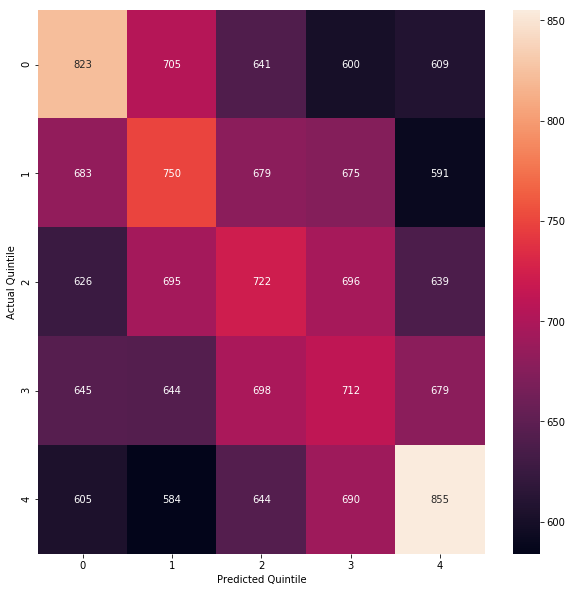

In [0]:

backtestmodel.evaluate_quantiles(chart=True, verbose=True)

## There is clearly some signal here. 

### Functions using Plotly to generate charts for performance, scatters, heatmaps

In [0]:
!pip install plotly==2.0.0

In [0]:
# chart performance

def mychart(args, names=None, title=""):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].values.reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        title = title,
        autosize=False,
        width=900,
        height=600,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [0]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width="600",
        height="480",
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [0]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

### Compare LASSO, OLS models

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
configure_plotly_browser_state()
perf_post_LASSO = backtestmodel.cumulative_return
mychart([perf_post_LASSO],["Post-LASSO"], title="Post-LASSO")


................................................................................
15:21:39 Still training step 80 of 563
................................................................................
15:21:56 Still training step 160 of 563
................................................................................
15:22:15 Still training step 240 of 563
................................................................................
15:22:35 Still training step 320 of 563
................................................................................
15:22:54 Still training step 400 of 563
................................................................................
15:23:14 Still training step 480 of 563
................................................................................
15:23:35 Still training step 560 of 563
...
Mean return: 3.545%
Monthly Sharpe ratio: 0.674
OOS MSE across all predictions: 41.4734
In-sample MSE: 35.7675
Variance: 39.4097
R-squared: -0.0524
Av

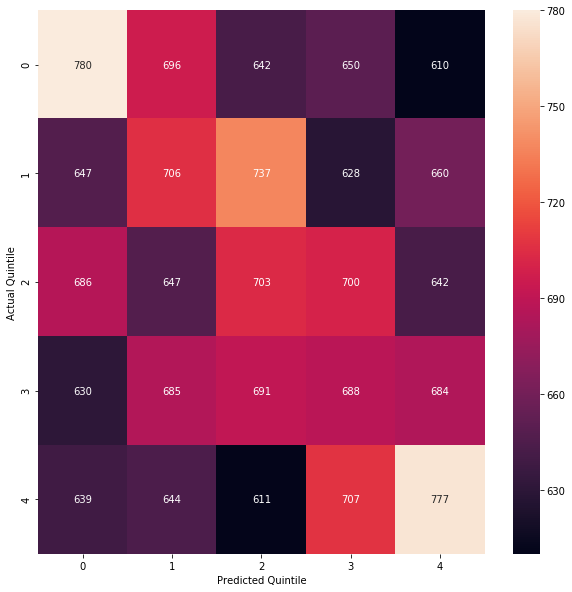

In [0]:
# You would expect it to perform worse, the other strategy looked into the future
configure_plotly_browser_state()
# do LASSO subset selection at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep",  # instead of feeding paper predictors, at each time step perform an online recalculation
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
perf_LASSO_each_timestep = backtestmodel.cumulative_return
mychart([perf_LASSO_each_timestep],["LASSO each timestep"], title="LASSO each timestep")



................................................................................
15:34:13 Still training step 80 of 563
................................................................................
15:34:16 Still training step 160 of 563
................................................................................
15:34:20 Still training step 240 of 563
................................................................................
15:34:24 Still training step 320 of 563
................................................................................
15:34:28 Still training step 400 of 563
................................................................................
15:34:32 Still training step 480 of 563
................................................................................
15:34:36 Still training step 560 of 563
...
Mean return: 2.781%
Monthly Sharpe ratio: 0.506
OOS MSE across all predictions: 43.8692
In-sample MSE: 34.7467
Variance: 39.4097
R-squared: -0.1132
Av

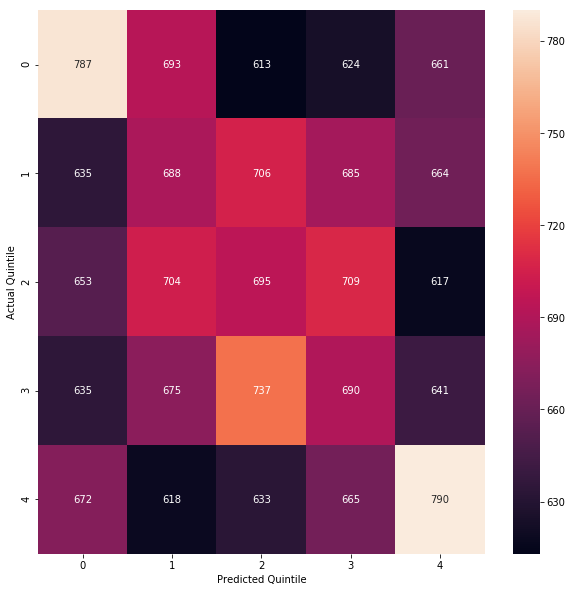

In [0]:
# use all predictors at each timestep
# without selection criteria you would expect performance to be lower, and indeed it is
configure_plotly_browser_state()
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_all_preds = backtestmodel.cumulative_return
mychart([perf_all_preds],["All preds"], title="OLS all predictors")


................................................................................
15:37:30 Still training step 80 of 563
................................................................................
15:37:45 Still training step 160 of 563
................................................................................
15:38:04 Still training step 240 of 563
................................................................................
15:38:23 Still training step 320 of 563
................................................................................
15:38:42 Still training step 400 of 563
................................................................................
15:39:01 Still training step 480 of 563
................................................................................
15:39:20 Still training step 560 of 563
...
Mean return: 3.077%
Monthly Sharpe ratio: 0.553
OOS MSE across all predictions: 40.0227
In-sample MSE: 36.1107
Variance: 39.4097
R-squared: -0.0156
Av

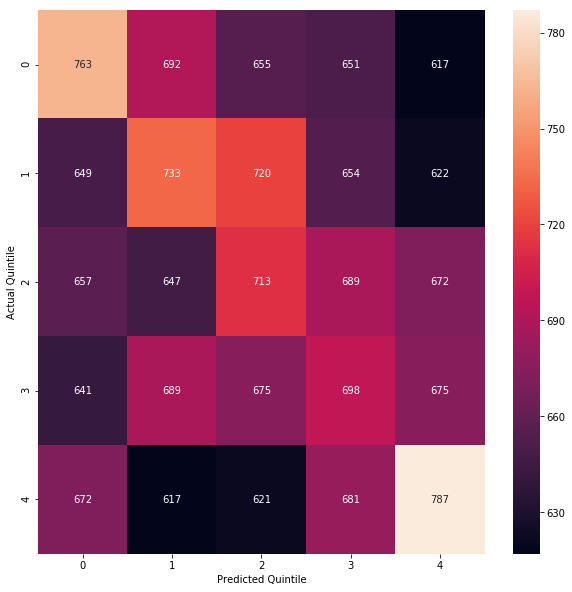

In [0]:
# pure LASSO (not LASSO followed by OLS on selected subset) (Shouldnt make a difference)
configure_plotly_browser_state()
def create_model_lasso():
    return LassoLarsIC(criterion='aic')    
    
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model_lasso, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=False)
perf_LASSO_only = backtestmodel.cumulative_return
mychart([perf_LASSO_only],["LASSO only"], title="LASSO only")


In [0]:
configure_plotly_browser_state()
mychart([perf_LASSO_each_timestep, perf_all_preds, perf_LASSO_only],["LASSO / OLS", "OLS Only", "LASSO only"])

### Use walk-forward cross-validation to evaluate a variety of sklearn regression algos

In [0]:
# test walk-forward xval, get a baseline MSE for LinearRegression: ~41
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)

backtestmodel.walkforward_xval(n_splits=5, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


15:48:07 Generate splits [137, 274, 411, 548, 684]
Steps: [137, 274, 411, 548]
Training on first 137 rows (0:136), putting predictions in rows range(137, 274)
.Training on first 274 rows (0:273), putting predictions in rows range(274, 411)
.Training on first 411 rows (0:410), putting predictions in rows range(411, 548)
.Training on first 548 rows (0:547), putting predictions in rows range(548, 684)
.
Mean return: 2.861%
Monthly Sharpe ratio: 0.575
OOS MSE across all predictions: 41.3994
In-sample MSE: 35.7131
Variance: 39.6015
R-squared: -0.0454
Avg rank correlation (Kendall's tau): 0.0253 (Expected: 0)
5-quintile accuracy: 0.2149 (Expected: 0.2)
Long/short/flat accuracy: 0.4562 (Expected: 0.44)
Excess true positive in quintiles 1 + 5: 170.200000


In [0]:
# try all the sklearn regression estimators
estimators = []

for name, class_ in all_estimators():
    if not issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.linear_model.bayes.ARDRegression'>
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>
<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>
<class 'sklearn.ensemble.bagging.BaggingRegressor'>
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
<class 'sklearn.linear_model.bayes.BayesianRidge'>
<class 'sklearn.cluster.birch.Birch'>
<class 'sklearn.cross_decomposition.cca_.CCA'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.dummy.DummyRegressor'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>
<class 'sklearn.covariance.elliptic_envelope.EllipticEnvelope'>
<class 'sklearn.tree.tree.ExtraTreeRegressor'>
<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
<class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegre

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning:

The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.



In [0]:
# eliminate some that didn't work, gave errors, nans, maybe need correct parameters
estimators = [
#     sklearn.ensemble.bagging.BaggingRegressor,
    sklearn.ensemble.forest.ExtraTreesRegressor,
    sklearn.ensemble.forest.RandomForestRegressor,
#     sklearn.ensemble.gradient_boosting.GradientBoostingRegressor,
    #sklearn.ensemble.iforest.IsolationForest,
    sklearn.ensemble.weight_boosting.AdaBoostRegressor,
    #sklearn.gaussian_process.gpr.GaussianProcessRegressor,
    sklearn.kernel_ridge.KernelRidge,
    sklearn.linear_model.base.LinearRegression,
    #sklearn.linear_model.bayes.ARDRegression, # takes a couple of hours
    sklearn.linear_model.bayes.BayesianRidge,
    sklearn.linear_model.coordinate_descent.ElasticNet,
#     sklearn.linear_model.coordinate_descent.ElasticNetCV,
#     sklearn.linear_model.coordinate_descent.Lasso,
#     sklearn.linear_model.coordinate_descent.LassoCV,
#     sklearn.linear_model.huber.HuberRegressor,
#     sklearn.linear_model.least_angle.Lars,
#     sklearn.linear_model.least_angle.LarsCV,
#     sklearn.linear_model.least_angle.LassoLars,
#     sklearn.linear_model.least_angle.LassoLarsCV,
#     sklearn.linear_model.least_angle.LassoLarsIC,
#     sklearn.linear_model.omp.OrthogonalMatchingPursuit,
#     sklearn.linear_model.omp.OrthogonalMatchingPursuitCV,
#     sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor,
#     sklearn.linear_model.ransac.RANSACRegressor,
#     sklearn.linear_model.ridge.Ridge,
#     sklearn.linear_model.ridge.RidgeCV,
#     sklearn.linear_model.stochastic_gradient.SGDRegressor,
    #sklearn.linear_model.theil_sen.TheilSenRegressor, very slow
    #sklearn.mixture.bayesian_mixture.BayesianGaussianMixture,
    #sklearn.mixture.gaussian_mixture.GaussianMixture,
    sklearn.neighbors.regression.KNeighborsRegressor,
    #sklearn.neighbors.regression.RadiusNeighborsRegressor, returned nan
    #sklearn.neural_network.multilayer_perceptron.MLPRegressor, slow, tried above 
    sklearn.svm.classes.LinearSVR,
    sklearn.svm.classes.NuSVR,
    #sklearn.svm.classes.OneClassSVM,
    #sklearn.svm.classes.SVR,
    #sklearn.tree.tree.DecisionTreeRegressor,
    #sklearn.tree.tree.ExtraTreeRegressor,
    #xgboost.XGBRegressor,
]
 

In [0]:
configure_plotly_browser_state()

# run all the models
sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

for estimator in estimators:
    print(str(estimator)[8:-2])
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=True, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")

    

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# make a dataframe with all the metrics
est_names = [str(estimator)[8:-2] for estimator in estimators]

skmetricsframe = pd.DataFrame(list(zip(est_names, mse_list, sharpe_list, quintile_accuracy_list, directional_accuracy_list,
                                     kendalltau_list, excess_tp_list)), columns = ['name', 'mse', 'sharpe', 'quantile_score', 
                                                                                   'direction_score', 'kendalltau', 
                                                                                   'truepositive_score'])

skmetricsframe.to_csv("output/sklearn_metrics.csv")

In [0]:
skmetricsframe = pd.read_csv("output/sklearn_metrics.csv")[['name','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
skmetricsframe


,name,mse,sharpe,quantile_score,direction_score,kendalltau,truepositive_score
0,sklearn.ensemble.forest.ExtraTreesRegressor,46.898537,0.282919,0.208585,0.451569,0.018279,97.8
1,sklearn.ensemble.forest.RandomForestRegressor,46.153709,0.433382,0.208999,0.452753,0.012594,108.8
2,sklearn.ensemble.weight_boosting.AdaBoostRegre...,42.528786,0.548382,0.208467,0.451569,0.024937,117.8
3,sklearn.kernel_ridge.KernelRidge,44.093757,0.470771,0.217525,0.464535,0.024320,212.8
4,sklearn.linear_model.base.LinearRegression,43.869152,0.505614,0.216104,0.465719,0.024582,225.8
5,sklearn.linear_model.bayes.BayesianRidge,39.745021,0.616943,0.221966,0.463233,0.035817,226.8
6,sklearn.linear_model.coordinate_descent.Elasti...,40.822586,0.530175,0.217466,0.462285,0.033173,208.8
7,sklearn.neighbors.regression.KNeighborsRegressor,43.934176,0.425237,0.212197,0.463173,0.021090,194.8
8,sklearn.svm.classes.LinearSVR,45.387514,0.179363,0.204500,0.449911,0.017196,72.8
9,sklearn.svm.classes.NuSVR,39.855374,-0.154537,0.211841,0.464417,-0.002250,115.8


In [0]:
with open('sklearn_table.html', 'w') as fo:
    skmetricsframe.sort_values(['kendalltau'], ascending=False).iloc[:12,:].to_html(fo, float_format=lambda x: '%.3f' % x)

In [0]:
# SGDRegressor diverged to 6.309236364118325e+23, omit out of range values for scatter chart
mse_list = skmetricsframe['mse'].values
mse_list = [x if x < 75 else np.nan for x in mse_list]
#mse_list[24] = np.nan
sharpe_list = skmetricsframe['sharpe'].values
kendalltau_list  = skmetricsframe['kendalltau'].values
excess_tp_list = skmetricsframe['truepositive_score'].values
quintile_accuracy_list = skmetricsframe['quantile_score'].values
directional_accuracy_list = skmetricsframe['direction_score'].values
# exclude > 100
#mse_list[20] = np.nan
#mse_list[21] = np.nan


In [0]:
configure_plotly_browser_state()
myscatter(mse_list, sharpe_list, title="Sharpe vs. MSE")
myscatter(quintile_accuracy_list, sharpe_list, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracy_list, sharpe_list, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltau_list, sharpe_list, title="Sharpe vs. Kendall's Tau")
myscatter(excess_tp_list, sharpe_list, title="Sharpe vs. True Positives")

In [0]:
configure_plotly_browser_state()
# 4-way plot
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('MSE', 'Quintile Accuracy','Direction Accuracy', "Kendall's tau"))
fig.append_trace(Scatter(
    x = mse_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=1)

fig.append_trace(Scatter(
    x = quintile_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=1, col=2)

fig.append_trace(Scatter(
    x = directional_accuracy_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=1)

fig.append_trace(Scatter(
    x = kendalltau_list,
    y = sharpe_list,
    mode = 'markers'
), row=2, col=2)


fig['layout'].update(height=1000, width=1000, title='Sharpe ratio scatters vs.')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [0]:
corrmatrix = skmetricsframe[['sharpe', 'mse',  'kendalltau', 
                           'quantile_score', 'direction_score', 'truepositive_score']].corr()
corrmatrix

,sharpe,mse,kendalltau,quantile_score,direction_score,truepositive_score
sharpe,1.000000,0.036948,0.888579,0.479062,0.070823,0.591833
mse,0.036948,1.000000,-0.167217,-0.592365,-0.597515,-0.451776
kendalltau,0.888579,-0.167217,1.000000,0.577180,0.154006,0.645630
quantile_score,0.479062,-0.592365,0.577180,1.000000,0.812051,0.917304
direction_score,0.070823,-0.597515,0.154006,0.812051,1.000000,0.836391
truepositive_score,0.591833,-0.451776,0.645630,0.917304,0.836391,1.000000


In [0]:
with open('sklearn_corr.html', 'w') as fo:
    corrmatrix.to_html(fo, float_format=lambda x: '%.3f' % x)

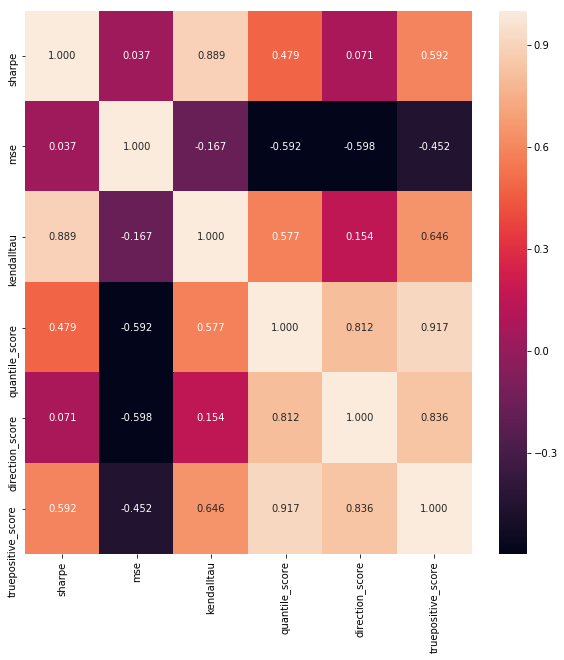

In [0]:
configure_plotly_browser_state()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmatrix, annot=True, fmt='.3f')
plt.show()


### Perform crossvalidation to find optimal regularization parameters for ElasticNet


In [0]:

sharpe_list = []
mse_list = []
kendalltau_list = []
excess_tp_list = []
quintile_accuracy_list = []
directional_accuracy_list = []
keys = []

def create_model(params):
    alpha, l1_ratio = params
    def myclosure():
        return sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    return myclosure

alphas = [1, 3, 10, 30, 100] 
l1_ratios = [.01, .05, .1, .5, .667, .75, .9, .95, .99, 1] # 1 = LASSO, 0 = Ridge

params_list = list(product(alphas, l1_ratios))
model_list = list(map(create_model, params_list))

for i in range(len(params_list)):
    print(params_list[i])
    estimator = model_list[i]
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=estimator,
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler=None)
    #backtestmodel.walkforward_xval(n_splits=5, verbose=False)
    backtestmodel.gen_predictions(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_predictions()
    backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    keys.append(str(estimator)[8:-2])
    sharpe_list.append(backtestmodel.sharpe)
    mse_list.append(backtestmodel.mse)
    kendalltau_list.append(backtestmodel.kendalltau)
    excess_tp_list.append(backtestmodel.excess_tp)
    quintile_accuracy_list.append(backtestmodel.quintile_accuracy)
    directional_accuracy_list.append(backtestmodel.directional_accuracy)
    print("---")


(1, 0.01)
................................................................................
18:14:01 Still training step 80 of 563
................................................................................
18:14:10 Still training step 160 of 563
................................................................................
18:14:22 Still training step 240 of 563
................................................................................
18:14:37 Still training step 320 of 563
................................................................................
18:14:51 Still training step 400 of 563
................................................................................
18:15:03 Still training step 480 of 563
................................................................................
18:15:17 Still training step 560 of 563
...
Mean return: 2.797%
Monthly Sharpe ratio: 0.507
OOS MSE across all predictions: 42.5880
In-sample MSE: 34.7849
Variance: 39.4097
R-squared: 

KeyboardInterrupt: ignored

In [0]:
# make a dataframe with all the metrics

flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(params_list, mse_list, sharpe_list, 
                                                                              quintile_accuracy_list, directional_accuracy_list, kendalltau_list, excess_tp_list):
    flatlist.append([key[0], key[1], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
metricsframe = pd.DataFrame(flatlist, columns = ['alpha', 'l1_ratio',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("output/ElasticNetmetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [0]:
metricsframe = pd.read_csv("output/ElasticNetmetrics.csv")[['alpha','l1_ratio','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

,alpha,l1_ratio,mse,sharpe,quantile_score,direction_score,kendalltau,truepositive_score
0,1,0.010,42.588025,0.506521,0.216341,0.464890,0.027456,223.8
1,1,0.050,42.384475,0.507739,0.217111,0.465127,0.028600,222.8
2,1,0.100,42.147649,0.546513,0.216992,0.464950,0.030210,228.8
3,1,0.500,40.822586,0.530175,0.217466,0.462285,0.033173,208.8
4,1,0.667,40.507056,0.561195,0.218117,0.463766,0.034161,221.8


In [0]:
with open('elastic_table.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:5,:].to_html(fo, float_format=lambda x: '%.3f' % x)

In [0]:
configure_plotly_browser_state()
# do full backtest using selected parameters for ElasticNet
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model((10, 0.1)),
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
#backtestmodel.walkforward_xval(n_splits=5, verbose=False)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)
    
mychart([ backtestmodel.cumulative_return, perf_LASSO_each_timestep],["ElasticNet", "LASSO/OLS"], title="ElasticNet v. LASSO/OLS")


................................................................................
18:19:02 Still training step 80 of 563
................................................................................
18:19:04 Still training step 160 of 563
................................................................................
18:19:06 Still training step 240 of 563
................................................................................
18:19:09 Still training step 320 of 563
................................................................................
18:19:11 Still training step 400 of 563
................................................................................
18:19:14 Still training step 480 of 563
................................................................................
18:19:17 Still training step 560 of 563
...
Mean return: 4.262%
Monthly Sharpe ratio: 0.695
OOS MSE across all predictions: 39.7252
In-sample MSE: 36.1142
Variance: 39.4097
R-squared: -0.0080
Av

In [0]:
# enumerate classifiers - didn't run these, maybe next time
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.multioutput.ClassifierChain'>
<class 'sklearn.naive_bayes.ComplementNB'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.dummy.DummyClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_

In [0]:
estimators

[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.multioutput.ClassifierChain,
 sklearn.naive_bayes.ComplementNB,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.dummy.DummyClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 s

### Perform cross-validation on Keras neural networks to select best architecture

In [0]:
# Didin't perform well leaving this for now. 
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 137
EPOCHS=1000
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(1,
                                 activation='linear',
                                 name='output%02d' % i)(lastlayer)
                          )
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="mse", metrics=["mse"], optimizer="adam", loss_weights=[1.]*OUTPUT_DIM)
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [Y[:,i] for i in range(OUTPUT_DIM)]
        
        if epochs:
            self.epochs = epochs

        retval = self.model.fit(X,
                                Y_list,
                                batch_size=BATCH_SIZE,
                                epochs=self.epochs,
                                verbose=verbose)
        self.history = retval.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return retval
    
    
    def predict(self, X, verbose=False):
        y_list = self.model.predict(X)
        # convert list of ys to Y array
        npreds=len(y_list[0])
        Y_pred = [y.reshape(npreds) for y in y_list]
        Y_pred = np.array(Y_pred).transpose()    
        return Y_pred
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


In [0]:
# no hidden layer, linear activation = LinearRegression
# confirm similar results to sklearn LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 0,
                                 reg_penalty = 0.0,
                                 verbose=True,
                                 epochs=2000)

In [0]:
backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=True))

# should match linear regression model pretty closely

In [0]:
# perform cross-validation on many Keras NN models
MODELPREFIX = "NN"


n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4, 8, 16]
reg_penalties = [0.0, 0.1, 0.3, 1, 3, 10, 30, 100]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
keys = []
mses = []
sharpes = []
quantile_scores = []
kendalltaus = []
excess_true_positives = []
directional_accuracies = []

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
    experiment_model.gen_returns(calc_returns, verbose=False)
    experiment_model.report_returns(start_date=start_date_str, freq='M')
    experiment_model.evaluate_predictions()
    experiment_model.evaluate_quantiles(chart=False, verbose=False)
    print("---")
    keys.append(key)
    mses.append(experiment_model.mse)
    quantile_scores.append(experiment_model.quintile_accuracy)
    directional_accuracies.append(experiment_model.directional_accuracy)
    kendalltaus.append(experiment_model.kendalltau)
    excess_true_positives.append(experiment_model.excess_tp)
    sharpes.append(experiment_model.sharpe)



In [0]:
# review metrics - not very good
flatlist = []
for key, mse, sharpe, quantile_score, directional_score, kt, excess_tp in zip(keys, mses, sharpes, 
                                                                              quantile_scores, directional_accuracies, kendalltaus, excess_true_positives):
    flatlist.append([key[0], key[1], key[2], mse, sharpe, quantile_score, directional_score, kt, excess_tp])
    
metricsframe = pd.DataFrame(flatlist, columns = ['layers', 'layer_size', 'reg_penalty',
                                                 'mse', 'sharpe', 'quantile_score', 
                                                 'direction_score', 'kendalltau', 'truepositive_score'])

metricsframe.to_csv("KerasNeuralNetMetrics.csv")
#metricsframe.sort_values(['kendalltau'], ascending=False)[['alpha','l1_ratio']].values[:12]

In [0]:
metricsframe = pd.read_csv("KerasNeuralNetMetrics.csv")[['layers','layer_size','reg_penalty','mse','sharpe','quantile_score','direction_score','kendalltau','truepositive_score']]
metricsframe

In [0]:
with open('nn_by_mse.html', 'w') as fo:
    metricsframe.sort_values(['mse'], ascending=True).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)
    
with open('nn_by_sharpe.html', 'w') as fo:
    metricsframe.sort_values(['sharpe'], ascending=False).iloc[:8,:].to_html(fo, float_format=lambda x: '%.3f' % x)    

In [0]:
plot_matrix(metricsframe, "layers", "layer_size", x_suffix=" layers", y_suffix=" units")
plot_matrix(metricsframe, "layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")
plot_matrix(metricsframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")

In [0]:
pd.DataFrame(metricsframe.groupby(['layers'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [0]:
pd.DataFrame(metricsframe.groupby(['layer_size'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [0]:
pd.DataFrame(metricsframe.groupby(['reg_penalty'])[['sharpe', 'mse', 'quantile_score', 'direction_score', 'kendalltau', 'truepositive_score']].mean())

In [0]:
myscatter(mses, sharpes, title="Sharpe vs. MSE")
myscatter(quantile_scores, sharpes, title="Sharpe vs. Quantile Accuracy")
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendalltaus, sharpes, title="Sharpe vs. Kendall's Tau")
myscatter(excess_true_positives, sharpes, title="Sharpe vs. True Positives")


In [0]:
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,3.0),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)
experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, 1, 16, 3)


In [0]:
# backtest 2, 16, 0.3 with walk-forward MSE of 116.058 and walk-forward Sharpe of 0.779
# full backtest Sharpe is 0.157

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(2,16,0.3),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)
experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, 2, 16, 0.3)
#Mean return: 0.835%
#Monthly Sharpe ratio: 0.157
#OOS MSE across all predictions: 125.1283
#In-sample MSE: 14.3808
#Variance: 39.4097
#R-squared: -2.1751
#Avg rank correlation (Kendall's tau): 0.0159 (Expected: 0)
#5-quintile accuracy: 0.2184 (Expected: 0.2)
#Long/short/flat accuracy: 0.4707 (Expected: 0.44)
#Excess true positive in quintiles 1 + 5: 207.800000

In [0]:
# backtest 1, 16, 30 with walk-forward MSE of 40.933 and walk-forward Sharpe of 0.411

def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              verbose=verbose)
# run selected model
experiment_model = BacktestModel(X, Y, 
                                 create_keras_model(1,16,30),
                                 coef_dict_param="all", 
                                 startindex=FIRST_TRAIN_MONTHS,
                                 fit_missing='mean',
                                 scaler=None)
experiment_model.gen_predictions(verbose=False)
#experiment_model.walkforward_xval(n_splits=5)
#experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, n_hidden_layers,layer_size,reg_penalty))
experiment_model.gen_returns(calc_returns, verbose=False)
experiment_model.report_returns(start_date=start_date_str, freq='M')
experiment_model.evaluate_predictions()
experiment_model.evaluate_quantiles(chart=False, verbose=False)
experiment_model.model.save("%s_%d%d_%.6f" % (MODELPREFIX, 1, 16, 30)



In [0]:
.....................................


12:32
